In [1]:
import os
from patchify import patchify
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from matplotlib import pyplot as plt
import joblib
from joblib import load
import time
import re

### Load patches into output_data

In [2]:
# Directory containing the npy files
dir_path = 'patches/'
# Get the list of .npy file names in the directory
file_list = os.listdir(dir_path)
# Filter the list for .npy files
file_list = [file for file in file_list if file.endswith('.npy')]
# Define a function to get the number from the file name
def extract_number(f):
    s = re.findall("\d+",f)
    return (int(s[0]) if s else -1,f)
# Sort the file list based on the numbers in the file names
file_list = sorted(file_list, key=extract_number)
# Initialize an empty list to store the arrays
arrays = []
# Load each .npy file into a numpy array and append it to the list
for file in file_list:
    array = np.load(dir_path + file)
    arrays.append(array)
# Stack all arrays along a new axis to create a single 4D array
output_data = np.stack(arrays)
output_data.shape

(92, 7, 9, 9)

## Prepare Training Dataset
- Extraction of 5 by 5 Patches from 9 by 9 Patches
- reshape patches into 1D arrays
<img src="img2.png" width="800" height="600">

In [3]:
small_patch_size = 5
centre = (small_patch_size-1) // 2

X = []
Y = []

for data in output_data:
    patches = patchify(data, (7, small_patch_size, small_patch_size), step=1)
    patches = patches.reshape(-1, 7, small_patch_size, small_patch_size)
    
    X_real = patches[:, 1:, :, :].real.reshape(patches.shape[0], -1)  # Real parts
    X_imag = patches[:, 1:, :, :].imag.reshape(patches.shape[0], -1)  # Imaginary parts
    X_patches = np.hstack((X_real, X_imag))  # Horizontal stack

    Y_patches = patches[:, 0, centre, centre]  # Central value of first layer
    Y_patches = Y_patches.real
    
    X.append(X_patches)
    Y.append(Y_patches)

# Convert lists to numpy arrays
X = np.concatenate(X)
Y = np.concatenate(Y)
print(X.shape)
print(Y.shape)

(2300, 300)
(2300,)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=4)

In [5]:
start_time = time.time()
model = RandomForestRegressor(n_estimators=138, 
                                  min_samples_split=2,
                                  min_samples_leaf=2,
                                  max_features=1.0,
                                  max_depth=80,
                                  bootstrap=True,
                                  random_state=42,
                                n_jobs=-1)
model.fit(x_train, y_train)
end_time = time.time()
duration = end_time - start_time
print("model training duration: ", duration,"s")

model training duration:  5.9445390701293945 s


In [6]:
y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error(s):', mae)

Mean Absolute Error(s): 0.007578013726834384


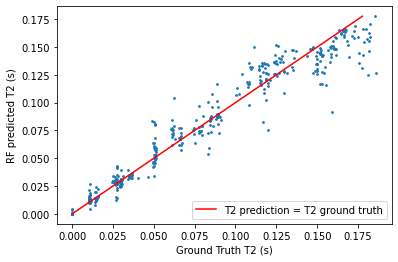

In [7]:
line = np.linspace(min(Y), max(y_pred), 1000)
plt.plot(line, line, 'r', label='T2 prediction = T2 ground truth')
plt.scatter(y_test,y_pred,s=3)
plt.xlabel('Ground Truth T2 (s)')
plt.ylabel('RF predicted T2 (s)')
plt.legend(loc='lower right')
#plt.title('RF model')
plt.show()